In [ ]:
import pandas as pd
from pathlib import Path

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Regression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from IPython.display import display

# K-Means Clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from collections import Counter

# PCA
from sklearn.decomposition import PCA

### STEP 2: EDA LEVEL 1
#### - Exploratory Data Analysis (EDA) 
#### - Level 1: Descriptive & Distribution

In [ ]:
# STEP 2.0 - LOAD DATA FROM CSV (from 1_dataset_construction.ipynb)

# Define paths
ROOT = Path.cwd().parents[0]
INPUT_DIR = ROOT / "analysis" / "data" 
csv_path = INPUT_DIR / "final_jobs_sample_50k.csv" # load global 500k data
print("csv_path: ", csv_path)

# Load data into DataFrame
df = pd.read_csv(
    csv_path,
    low_memory=False
)

# Display settings for unlimited rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 30) # Adjust the maximum column width

df.head()

csv_path:  d:\Work_Study\IT\Data\Projects\data_industry_insights\analysis\data\final_jobs_sample_50k.csv


,job_id,company_id,location_id,posted_date,min_salary,max_salary,currency,required_exp_years,education_level,employment_type,job_description,remote_option,company_name,size,industry,city,country,country_iso,latitude,longitude,population,roles,job_level,skill_names,skill_ids,skill_categories
0,119761,17828,4493,2025-05-31,120000.0,140000.0,NaN,NaN,Master,Full-time,Enterprise Account Executi...,Remote,Maslow,Enterprise,Technology,Auckland,New Zealand,NZ,-41.66257875715869,172.70192594405574,4917000.0,NaN,Lead,NaN,NaN,NaN
1,1088383,153166,4700,2025-01-11,NaN,NaN,NaN,NaN,NaN,Full-time,__NA__,Onsite,MASTER PLUS HUMAN RESOURCE...,NaN,NaN,Oshkosh,United States of America,US,45.70562800215178,-112.5994359115045,328239523.0,Data Engineer,NaN,"Azure, AWS, Kafka, Terrafo...","1, 10, 11, 17, 18, 20, 23,...","Cloud,Data Engineering,Dev..."
2,853689,32657,1406,2024-06-08,NaN,NaN,NaN,NaN,NaN,Full-time,__NA__,Onsite,RemoteWorker UK,NaN,NaN,London Village,Kiribati,KI,1.8732,-157.4296,312000.0,Data Scientist,NaN,"Azure, Python, AWS, GCP, G...","1, 9, 10, 15, 37, 57, 134,...","Cloud,Programming,DevOps,V..."
3,850850,95060,5439,2024-06-03,NaN,NaN,NaN,NaN,NaN,Full-time,__NA__,Onsite,25-я городская детская пол...,NaN,NaN,Minsk Mazowiecki,Poland,PL,52.14826021933187,19.31101430844868,37970874.0,Data Analyst,NaN,NaN,NaN,NaN
4,920654,66126,5394,2024-09-12,NaN,NaN,NaN,NaN,NaN,Full-time,__NA__,Onsite,Bbva Renting,NaN,NaN,Bogota,United States of America,US,45.70562800215178,-112.5994359115045,328239523.0,Data Analyst,NaN,"SQL, Python, Spark, PowerP...","8, 9, 18, 41","Database,Programming,Data ..."


In [ ]:
# STEP 2.1: PREPARE DATA FOR ANALYSIS

# Convert 'posted_date' to datetime
df['posted_date'] = pd.to_datetime(df['posted_date'], errors='coerce')

# Convert coordinate and population columns to numeric
numeric_cols = ['latitude', 'longitude', 'population', 'min_salary', 'max_salary', 'required_exp_years']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Optimize categorical columns
# Added 'job_level' here as it usually has fixed values (Senior, Junior, etc.)
categorical_cols = [
    'employment_type', 'remote_option', 'education_level',
    'size', 'industry', 'country', 'country_iso', 'currency', 'job_level'
]

for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Handle ID columns
id_cols = ['job_id', 'company_id', 'location_id', 'skill_ids']
for col in id_cols:
    if col in df.columns:
        df[col] = df[col].astype(str)

# Ensure new text-based columns are clean strings
text_cols = ['roles', 'skill_names', 'skill_categories']
for col in text_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).replace('None', pd.NA)

# Verify the changes
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   job_id              50000 non-null  object        
 1   company_id          50000 non-null  object        
 2   location_id         50000 non-null  object        
 3   posted_date         50000 non-null  datetime64[ns]
 4   min_salary          438 non-null    float64       
 5   max_salary          438 non-null    float64       
 6   currency            38 non-null     category      
 7   required_exp_years  71 non-null     float64       
 8   education_level     1207 non-null   category      
 9   employment_type     50000 non-null  category      
 10  job_description     50000 non-null  object        
 11  remote_option       50000 non-null  category      
 12  company_name        50000 non-null  object        
 13  size                2175 non-null   category  

In [ ]:
# STEP 2.2: CHECK CURRENCY COUNTS ---

# Detailed statistics for each currency unit
# value_counts(dropna=False) ensures we see the count for missing values (NaN)
currency_stats = df['currency'].value_counts(dropna=False).reset_index()
currency_stats.columns = ['Currency Unit', 'Row Count']

# Add a percentage column for better context
currency_stats['Percentage (%)'] = (currency_stats['Row Count'] / len(df) * 100).round(2)

print("--- Detailed Currency Statistics ---")
print(currency_stats)

# Summary of unique units
unique_units = df['currency'].nunique()
missing_values = df['currency'].isna().sum()

print(f"\nSummary:")
print(f"- Total unique currency units found: {unique_units}")
print(f"- Total rows missing currency (NaN): {missing_values} ({ (missing_values/len(df)*100):.2f}%)")

--- Detailed Currency Statistics ---
  Currency Unit  Row Count  Percentage (%)
0           NaN      49962           99.92
1           USD         33            0.07
2           PLN          3            0.01
3           EUR          2            0.00

Summary:
- Total unique currency units found: 3
- Total rows missing currency (NaN): 49962 (99.92%)


In [ ]:
# STEP 2.3: CONVERT ALL CURRENCY TO USD ---

# Fill missing currencies with 'USD' ONLY IF there is salary data
# This fulfills your requirement: "rows with min/max salary but empty currency -> fill as USD"
mask_missing_currency = (df['currency'].isna()) & (df['min_salary'].notna() | df['max_salary'].notna())
df.loc[mask_missing_currency, 'currency'] = 'USD'

# Define Exchange Rates (Update these values if needed)
exchange_rates = {
    'USD': 1.0,
    'EUR': 1.08,
    'PLN': 0.25
}

# Map exchange rates (Default to 1.0 if still unknown)
df['ex_rate'] = df['currency'].map(exchange_rates).astype(float).fillna(1.0)

# Convert salary columns to USD
df['min_salary_usd'] = df['min_salary'] * df['ex_rate']
df['max_salary_usd'] = df['max_salary'] * df['ex_rate']

# Calculate average salary in USD
df['avg_salary_usd'] = df[['min_salary_usd', 'max_salary_usd']].mean(axis=1)

# Final Check
print("--- Final Salary Conversion Summary ---")
print(f"Total rows forced to USD (missing currency but had salary): {mask_missing_currency.sum()}")
print(f"Total jobs with valid USD salary: {df['avg_salary_usd'].notnull().sum()}")
print("\nSample of converted data:")
print(df[df['avg_salary_usd'].notnull()][['currency', 'min_salary', 'max_salary', 'avg_salary_usd']].head(10))

--- Final Salary Conversion Summary ---
Total rows forced to USD (missing currency but had salary): 400
Total jobs with valid USD salary: 438

Sample of converted data:
     currency  min_salary  max_salary  avg_salary_usd
0         USD   120000.00   140000.00       130000.00
839       USD   172771.44   172771.44       172771.44
864       USD   120582.73   120582.73       120582.73
1000      USD    85603.79    85603.79        85603.79
1019      USD   119809.00   119809.00       119809.00
1184      USD    47642.09    47642.09        47642.09
1445      USD   130000.00   130000.00       130000.00
1506      USD    50291.92    50291.92        50291.92
1653      USD   156000.00   208000.00       182000.00
1654      USD    46451.56    46451.56        46451.56


In [ ]:
# STEP 2.4: CHECK MISSING SALARY AND FILL

# Check missing values come from what countries
missing = df[df['min_salary_usd'].isna()][['country', 'currency']] # Show rows with missing salary usd, and show 2 columns

 # Drop duplicates countries
country_count_NA = missing.drop_duplicates()

# Summary
print("Total countrys with missing data:", len(country_count_NA))
print(country_count_NA)

Total countrys with missing data: 127
                             country currency
1           United States of America      NaN
2                           Kiribati      NaN
3                             Poland      NaN
5                              Italy      NaN
6                              India      NaN
10                           Vietnam      NaN
11                          Pakistan      NaN
14                            Serbia      NaN
15                              Cuba      NaN
16                           Germany      NaN
19                         Venezuela      NaN
27                            Israel      NaN
33                            Mexico      NaN
44                      South Africa      NaN
53                    United Kingdom      NaN
60                            Sweden      NaN
61                            France      NaN
64                             Spain      NaN
68                            Turkey      NaN
84                        Luxembourg      

In [ ]:
# STEP 2.4: CHECK MISSING SALARY AND FILL

# Calculate average salary in USD

df_avg_salary = df.groupby(['country', 'currency']).agg(
    jobs=('job_id', 'count'),
    avg_salary_usd=('avg_salary_usd', 'mean')
).reset_index()

df_avg_salary.head()

C:\Users\Zyro\AppData\Local\Temp\ipykernel_17080\4129969560.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_avg_salary = df.groupby(['country', 'currency']).agg(


,country,currency,jobs,avg_salary_usd
0,Afghanistan,EUR,0,NaN
1,Afghanistan,PLN,0,NaN
2,Afghanistan,USD,0,NaN
3,Albania,EUR,0,NaN
4,Albania,PLN,0,NaN


In [ ]:
# STEP 2.4: CHECK MISSING SALARY AND FILL

# Summary

salary_cols = ['min_salary_usd', 'max_salary_usd', 'avg_salary_usd']

# min, median (50%), mean, max
summary = df[salary_cols].agg(['min', 'median', 'mean', 'max']).T

# Format USD
summary_formatted = summary.applymap(lambda x: f"${x:,.2f}")

summary_formatted.rename(columns={
    'min': 'Minimum',
    'median': 'Median',
    'mean': 'Average',
    'max': 'Maximum'
}, inplace=True)

# Visual
print("\n" + "="*50)
print("💼 SALARY SUMMARY (USD) 💼")
print("="*50)
print(summary_formatted)


💼 SALARY SUMMARY (USD) 💼
                   Minimum       Median      Average      Maximum
min_salary_usd  $10,400.00  $104,000.00  $133,128.12  $480,000.00
max_salary_usd  $13,000.00  $119,080.00  $152,353.64  $500,000.00
avg_salary_usd  $11,700.00  $111,540.00  $142,740.88  $480,000.00


C:\Users\Zyro\AppData\Local\Temp\ipykernel_17080\1164374639.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary_formatted = summary.applymap(lambda x: f"${x:,.2f}")


In [ ]:
# STEP 2.5: DESCRIBE

# For Numbers
print("--- NUMERICAL STATS ---")
display(df.describe())

# For Text
print("\n--- CATEGORICAL STATS ---")
display(df.describe(include='object'))

--- NUMERICAL STATS ---


,posted_date,min_salary,max_salary,required_exp_years,latitude,longitude,population,ex_rate,min_salary_usd,max_salary_usd,avg_salary_usd
count,50000,438.000000,438.000000,71.000000,49928.000000,49928.000000,4.992800e+04,50000.000000,438.000000,438.000000,438.000000
mean,2024-05-16 10:49:29.856000256,133302.967466,152560.698059,4.183099,34.819819,-35.838865,2.058344e+08,0.999958,133128.123995,152353.643082,142740.883539
min,2021-04-17 00:00:00,40969.710000,40969.710000,0.000000,-41.662579,-157.429600,4.500000e+04,0.250000,10400.000000,13000.000000,11700.000000
25%,2023-10-16 00:00:00,65318.120000,72741.792500,2.000000,23.935372,-112.599436,5.855827e+07,1.000000,65318.120000,72180.597500,69250.000000
50%,2024-01-13 00:00:00,104000.000000,119080.000000,5.000000,42.751183,-8.010237,6.962558e+07,1.000000,104000.000000,119080.000000,111540.000000
75%,2024-11-21 00:00:00,156000.000000,160000.000000,6.000000,45.705628,12.140788,3.282395e+08,1.000000,156000.000000,160000.000000,156000.000000
max,2025-12-31 00:00:00,480000.000000,500000.000000,9.000000,64.578700,172.701926,1.397715e+09,1.080000,480000.000000,500000.000000,480000.000000
std,NaN,91903.685709,116843.528949,2.146824,20.091057,77.042978,2.667613e+08,0.005831,92325.870808,117377.152675,103762.592555



--- CATEGORICAL STATS ---


,job_id,company_id,location_id,job_description,company_name,city,roles,skill_names,skill_ids,skill_categories
count,50000,50000,50000,50000,50000,39290,50000,50000,50000,50000
unique,50000,24889,3359,644,24889,3340,43,19220,19220,1682
top,119761,37815,5370,__NA__,Emprego,Singapore,Data Engineer,nan,nan,nan
freq,1,667,10457,48362,667,1549,18339,9365,9365,9365


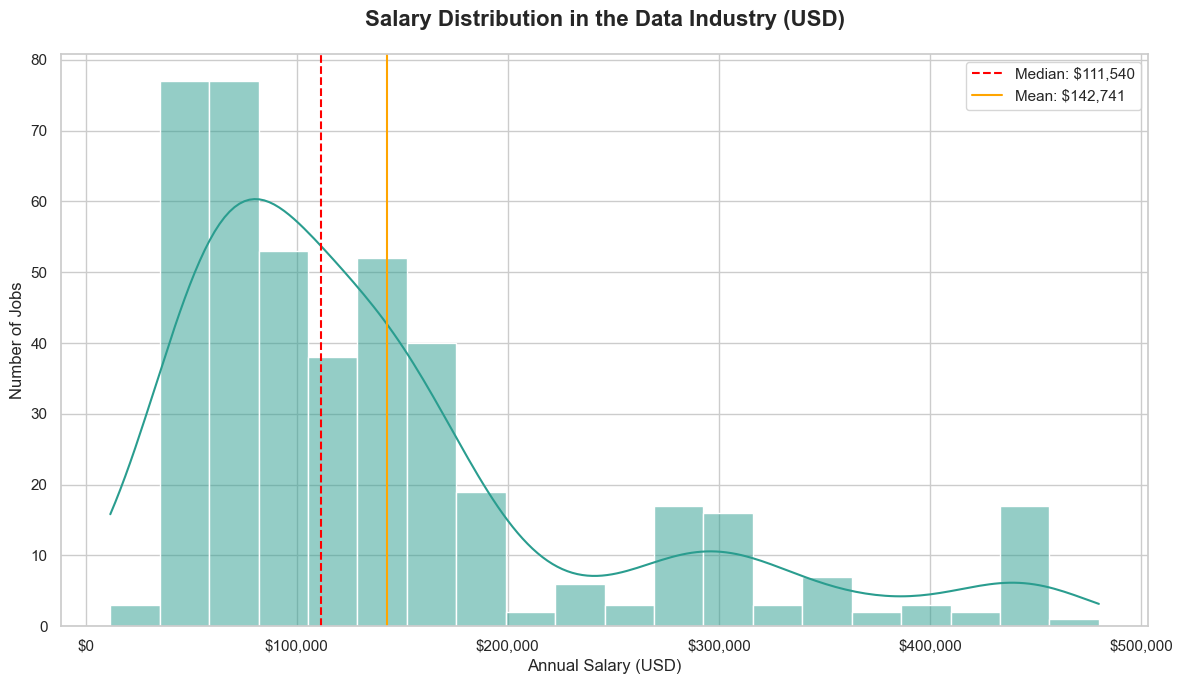

In [ ]:
# STEP 2.6: CHARTS SALARY DISTRIBUTION

# Filter data to include only non-null salary records
salary_data = df[df['avg_salary_usd'].notnull()]

# Set the visual theme
plt.figure(figsize=(12, 7))
sns.set_theme(style="whitegrid")

# Create Histogram with Kernel Density Estimate (KDE)
# This shows the shape of the distribution
sns.histplot(salary_data['avg_salary_usd'], kde=True, color='#2a9d8f', bins=20)

# Add vertical lines for statistical context
# These lines help identify if the data is skewed
median_val = salary_data['avg_salary_usd'].median()
mean_val = salary_data['avg_salary_usd'].mean()

plt.axvline(median_val, color='red', linestyle='--', label=f'Median: ${median_val:,.0f}')
plt.axvline(mean_val, color='orange', linestyle='-', label=f'Mean: ${mean_val:,.0f}')

# Add Titles and Labels
plt.title('Salary Distribution in the Data Industry (USD)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Annual Salary (USD)', fontsize=12)
plt.ylabel('Number of Jobs', fontsize=12)
plt.legend()

# Format the X-axis to show currency
formatter = ticker.StrMethodFormatter('${x:,.0f}')
plt.gca().xaxis.set_major_formatter(formatter)

# Adjust spacing
plt.tight_layout()
plt.show()

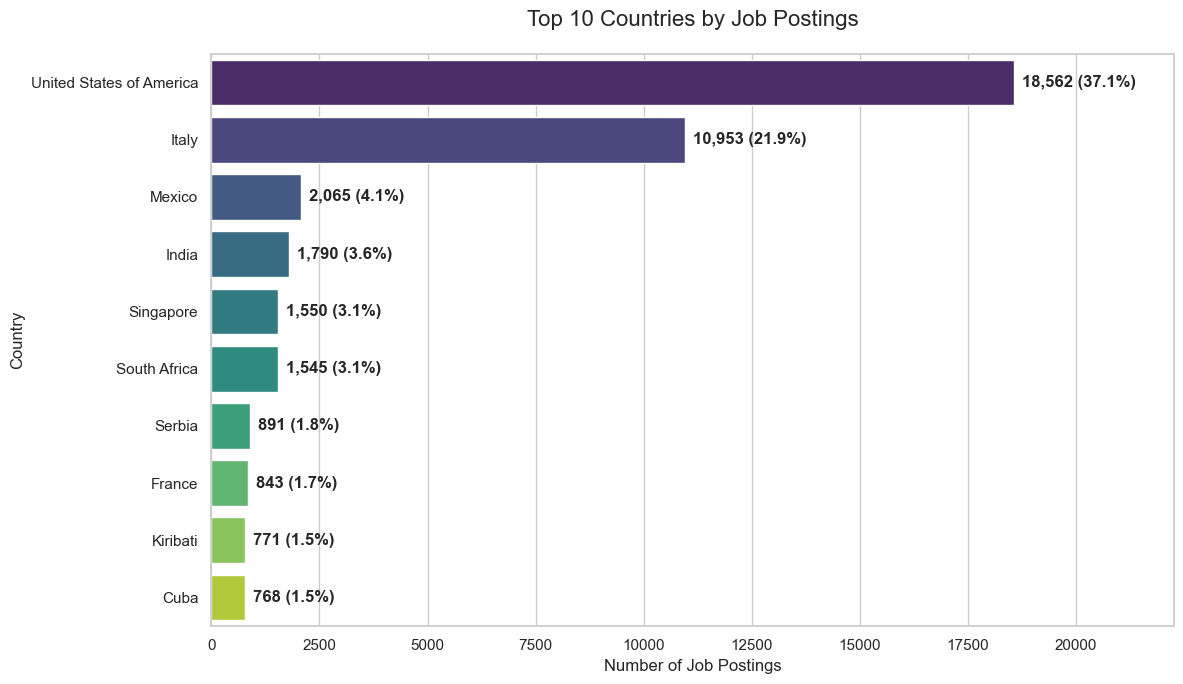

In [ ]:
# STEP 2.7: CHARTS COUNTRIES DISTRIBUTION

# Clear previous figures to avoid overlapping
plt.close('all')

# Extract Top 10 and REMOVE unused categories
# 'remove_unused_categories()' is the key to fixing the crowded Y-axis
top_10_df = df['country'].value_counts().head(10).reset_index()
top_10_df.columns = ['Country', 'JobCount']

# IMPORTANT: If 'Country' is a Categorical type, we must cast it to string
# or remove the hidden categories so they don't appear in the plot
top_10_df['Country'] = top_10_df['Country'].astype(str)

# Calculate %
total_jobs = len(df)
top_10_df['Pct'] = (top_10_df['JobCount'] / total_jobs) * 100

# Plotting
plt.figure(figsize=(12, 7))
sns.barplot(
    data=top_10_df,
    x='JobCount',
    y='Country',
    hue='Country',      # Maps color to the country name
    palette='viridis',
    legend=False
)

# Add text labels with counts and percentages
for i, row in top_10_df.iterrows():
    label = f"{int(row['JobCount']):,} ({row['Pct']:.1f}%)"
    plt.text(row['JobCount'] + (top_10_df['JobCount'].max() * 0.01), i, label, va='center', fontweight='bold')

# Professional English Labels
plt.title('Top 10 Countries by Job Postings', fontsize=16, pad=20)
plt.xlabel('Number of Job Postings', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.xlim(0, top_10_df['JobCount'].max() * 1.2) # Add space for labels
plt.tight_layout()
plt.show()

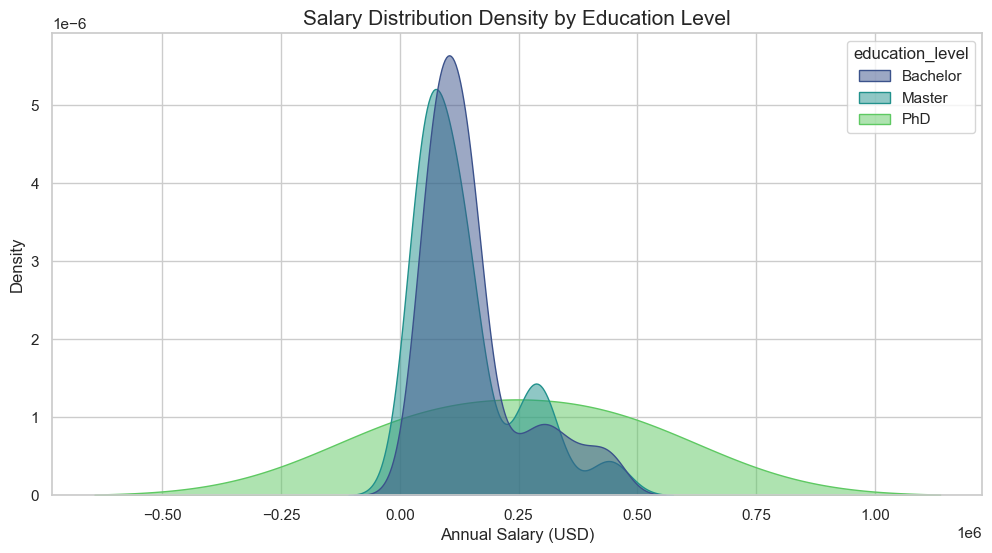

In [ ]:
# STEP 2.8: CHARTS SALARY DISTRIBUTION BY EDUCATION LEVEL

# Filter for rows that have both salary and education level
df_edu = df[df['avg_salary_usd'].notnull() & df['education_level'].notnull()]

# Plotting
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df_edu, x='avg_salary_usd', hue='education_level', fill=True, common_norm=False, palette='viridis', alpha=.5)

# Add vertical lines for median salaries by education level
plt.title('Salary Distribution Density by Education Level', fontsize=15)
plt.xlabel('Annual Salary (USD)')
plt.ylabel('Density')
plt.show()

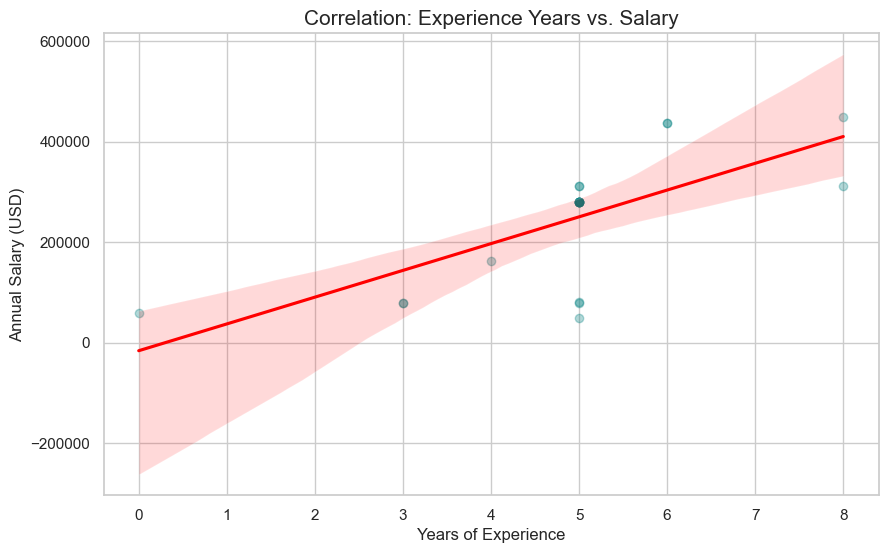

In [ ]:
# STEP 2.9: CHARTS EXPERIENCE VS. SALARY

# Charts the relationship between years of experience and salary
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='required_exp_years', y='avg_salary_usd',
            scatter_kws={'alpha':0.3, 'color':'teal'}, line_kws={'color':'red'})

# Add title and labels
plt.title('Correlation: Experience Years vs. Salary', fontsize=15)
plt.xlabel('Years of Experience')
plt.ylabel('Annual Salary (USD)')
plt.show()

In [ ]:
# STEP 2.9: CHARTS EXPERIENCE VS. SALARY

# Check correlation by Pearson and Spearman (2.9 Expanse)
df_corr_pearson = df[['required_exp_years', 'avg_salary_usd']].corr(method='pearson')
df_corr_spearman = df[['required_exp_years', 'avg_salary_usd']].corr(method='spearman')

# Visual
print("Correlation (Pearson):")
print(df_corr_pearson, "\n")
print("Correlation (Spearman):")
print(df_corr_spearman)

Correlation (Pearson):
                    required_exp_years  avg_salary_usd
required_exp_years            1.000000        0.680847
avg_salary_usd                0.680847        1.000000 

Correlation (Spearman):
                    required_exp_years  avg_salary_usd
required_exp_years            1.000000        0.793779
avg_salary_usd                0.793779        1.000000


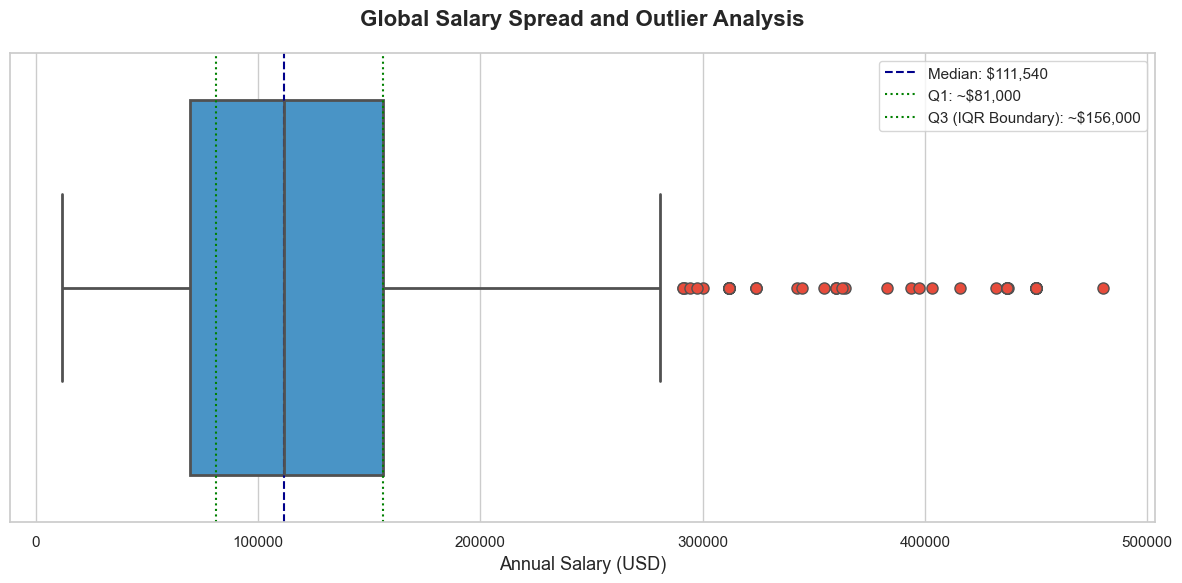

In [ ]:
# STEP 2.10: CHARTS GLOBAL SALARY SPREAD

# Set plot style and size
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create the Boxplot
# Change 'avg_salary_usd' to match your actual column name exactly
ax = sns.boxplot(x=df['avg_salary_usd'],
                 color='#3498db',
                 linewidth=2,
                 flierprops={'markerfacecolor':'#e74c3c', 'marker':'o', 'markersize':8})

# Add titles and labels in English
plt.title('Global Salary Spread and Outlier Analysis', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Annual Salary (USD)', fontsize=13)

# Annotating key statistics (Values based on your Section 3.2 data)
median_val = 111540
q1_val = 81000   # Approximate 25th percentile
q3_val = 156000  # Approximate 75th percentile

# Draw vertical lines for better visualization
plt.axvline(median_val, color='darkblue', linestyle='--', label=f'Median: ${median_val:,.0f}')
plt.axvline(q1_val, color='green', linestyle=':', label=f'Q1: ~${q1_val:,.0f}')
plt.axvline(q3_val, color='green', linestyle=':', label=f'Q3 (IQR Boundary): ~${q3_val:,.0f}')

# Display Legend
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

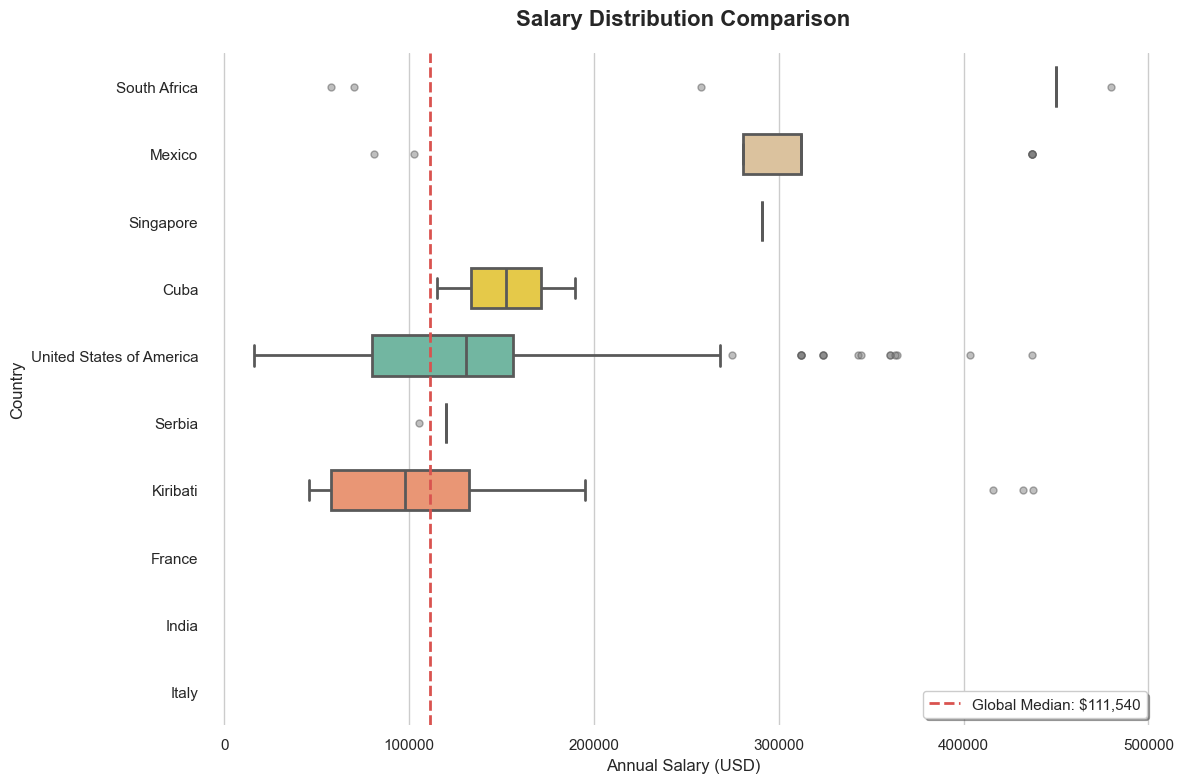

In [ ]:
# STEP 2.11: CHARTS SALARY DISTRIBUTION BY COUNTRY

# Total Reset of the plotting environment
plt.close('all')
plt.cla()
plt.clf()

# Identify the REAL Top 10 countries by volume (number of job listings)
# This prevents rare countries from appearing in the Top 10
top_10_names = df['country'].value_counts().nlargest(10).index.tolist()

# Force-create a new DataFrame to break all categorical memory
# We use .copy() and reset_index to ensure a clean slate
df_plot = df[df['country'].isin(top_10_names)].copy()
df_plot['country'] = df_plot['country'].astype(str)

# Sorting logic for a professional hierarchy
order_list = df_plot.groupby('country')['avg_salary_usd'].median().sort_values(ascending=False).index

# Visual Configuration (Solid Light Colors - Professional Style)
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Using 'Set2' for professional, solid light colors
ax = sns.boxplot(
    data=df_plot,
    y='country',
    x='avg_salary_usd',
    order=order_list,
    hue='country',
    palette='Set2',
    width=0.6,
    linewidth=2,
    fliersize=5,
    flierprops={'markerfacecolor': 'gray', 'alpha': 0.5}
)

# Global Median Benchmark Line (Red)
global_med = df['avg_salary_usd'].median()
plt.axvline(global_med, color='#d9534f', linestyle='--', linewidth=2, label=f'Global Median: ${global_med:,.0f}')

# Professional English Labels
plt.title('Salary Distribution Comparison', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Annual Salary (USD)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.legend(loc='lower right', frameon=True, shadow=True)

# Remove outer spines for clarity
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

In [ ]:
# STEP 2.11: CHARTS SALARY DISTRIBUTION BY COUNTRY

# Check df
df.head()

,job_id,company_id,location_id,posted_date,min_salary,max_salary,currency,required_exp_years,education_level,employment_type,job_description,remote_option,company_name,size,industry,city,country,country_iso,latitude,longitude,population,roles,job_level,skill_names,skill_ids,skill_categories,ex_rate,min_salary_usd,max_salary_usd,avg_salary_usd
0,119761,17828,4493,2025-05-31,120000.0,140000.0,USD,NaN,Master,Full-time,Enterprise Account Executi...,Remote,Maslow,Enterprise,Technology,Auckland,New Zealand,NZ,-41.662579,172.701926,4917000.0,nan,Lead,nan,nan,nan,1.0,120000.0,140000.0,130000.0
1,1088383,153166,4700,2025-01-11,NaN,NaN,NaN,NaN,NaN,Full-time,__NA__,Onsite,MASTER PLUS HUMAN RESOURCE...,NaN,NaN,Oshkosh,United States of America,US,45.705628,-112.599436,328239523.0,Data Engineer,NaN,"Azure, AWS, Kafka, Terrafo...","1, 10, 11, 17, 18, 20, 23,...","Cloud,Data Engineering,Dev...",1.0,NaN,NaN,NaN
2,853689,32657,1406,2024-06-08,NaN,NaN,NaN,NaN,NaN,Full-time,__NA__,Onsite,RemoteWorker UK,NaN,NaN,London Village,Kiribati,KI,1.873200,-157.429600,312000.0,Data Scientist,NaN,"Azure, Python, AWS, GCP, G...","1, 9, 10, 15, 37, 57, 134,...","Cloud,Programming,DevOps,V...",1.0,NaN,NaN,NaN
3,850850,95060,5439,2024-06-03,NaN,NaN,NaN,NaN,NaN,Full-time,__NA__,Onsite,25-я городская детская пол...,NaN,NaN,Minsk Mazowiecki,Poland,PL,52.148260,19.311014,37970874.0,Data Analyst,NaN,nan,nan,nan,1.0,NaN,NaN,NaN
4,920654,66126,5394,2024-09-12,NaN,NaN,NaN,NaN,NaN,Full-time,__NA__,Onsite,Bbva Renting,NaN,NaN,Bogota,United States of America,US,45.705628,-112.599436,328239523.0,Data Analyst,NaN,"SQL, Python, Spark, PowerP...","8, 9, 18, 41","Database,Programming,Data ...",1.0,NaN,NaN,NaN


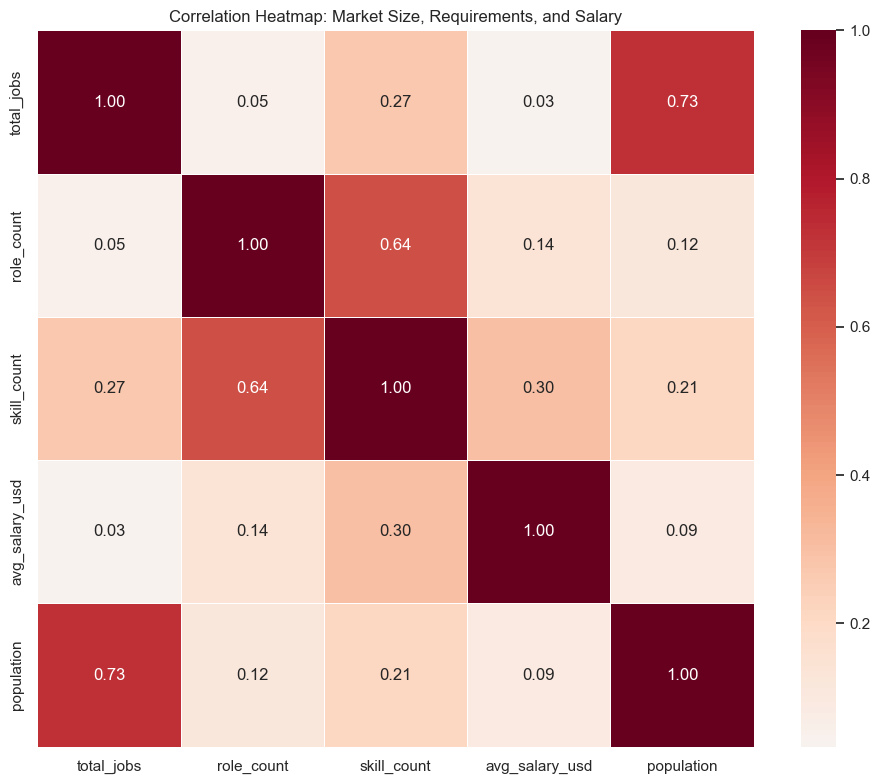

In [ ]:
# STEP 2.12 : CORRELATION HEATMAP

import matplotlib.pyplot as plt
import seaborn as sns

# Item Counting Function
def count_items(text):
    if pd.isna(text) or str(text).strip() == "" or str(text).lower() in ['none', 'nan']:
        return 0
    # Count based on commas
    return len([i.strip() for i in str(text).split(',') if i.strip() != ""])

# FIX: Ensure columns exist and use the correct names from your dataset
# We use 'skill_names' because that is what your dataset actually contains.
if 'skills' not in df.columns and 'skill_names' in df.columns:
    df['skills'] = df['skill_names'].astype(str).replace(['nan', 'None'], '')
elif 'skills' not in df.columns:
    df['skills'] = ""

if 'roles' in df.columns:
    df['roles'] = df['roles'].astype(str).replace(['nan', 'None'], '')
else:
    df['roles'] = ""

# Create count columns for heatmap
df['role_count'] = df['roles'].apply(count_items)
df['skill_count'] = df['skills'].apply(count_items)

# Convert critical columns to numeric (Ensuring avg_salary_usd is included)
cols_to_fix = ['avg_salary_usd', 'population', 'role_count', 'skill_count']
for col in cols_to_fix:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Group by Country
# Use observed=True to handle Categorical types correctly
df_country_stats = df.groupby('country', observed=True).agg({
    'job_id': 'count',
    'role_count': 'mean',
    'skill_count': 'mean',
    'avg_salary_usd': 'mean', # Using the USD standardized salary we created
    'population': 'mean'      # Using mean population in case of duplicate entries
}).rename(columns={'job_id': 'total_jobs'})

# Cleaning: Remove countries with no data to avoid NaN in correlation matrix
df_country_stats = df_country_stats.dropna()

# Plot Correlation Heatmap
plt.figure(figsize=(10, 8))
country_corr = df_country_stats.corr()

sns.heatmap(country_corr,
            annot=True,
            cmap='RdBu_r',
            center=0,
            fmt=".2f",
            square=True,
            linewidths=.5)

plt.title('Correlation Heatmap: Market Size, Requirements, and Salary')
plt.tight_layout()
plt.show()

In [ ]:
# STEP 2.13: ANOVA ANALYSIS

# Pre-processing: Align column names and metrics
# We use the 'skills' and 'roles' columns prepared in Step 5
if 'skills' not in df.columns and 'skill_names' in df.columns:
    df['skills'] = df['skill_names'].astype(str).replace(['nan', 'None'], '')

# repare Data for ANOVA
# Filter only rows that have a valid salary (using our standardized USD column)
df_filtered = df.dropna(subset=['min_salary_usd'])

# Get Top 5 countries with the most salary data points for a valid test
top_countries = df_filtered['country'].value_counts().nlargest(5).index
df_anova_base = df_filtered[df_filtered['country'].isin(top_countries)].copy()

# Ensure country is a string to avoid categorical index errors in statsmodels
df_anova_base['country'] = df_anova_base['country'].astype(str)

# List of Metrics to test
factors_to_test = ['skill_count', 'min_salary_usd', 'role_count']

print(f"=== ANOVA ANALYSIS REPORT: TOP 5 COUNTRIES ===")
print(f"Countries analyzed: {', '.join(top_countries)}\n")

for factor in factors_to_test:
    # Clean data for the specific factor
    df_clean = df_anova_base.dropna(subset=[factor, 'country'])

    # Check if there's enough data (need at least some rows per country)
    if df_clean.empty or len(df_clean['country'].unique()) < 2:
        print(f"Skipping {factor}: Not enough data for comparison.\n")
        continue

    # Build OLS Model and Run ANOVA
    # C(country) treats the country names as categorical groups
    try:
        formula = f'{factor} ~ C(country)'
        model = ols(formula, data=df_clean).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)

        # Business Format Display
        print(f"--- ANOVA RESULTS FOR: {factor.upper()} ---")

        p_val = anova_table['PR(>F)'].iloc[0]
        f_stat = anova_table['F'].iloc[0]

        print(f"F-statistic: {f_stat:.4f}")

        if p_val < 0.05:
            print(f"Result: STATISTICALLY SIGNIFICANT (P-value = {p_val:.4e})")
            print(f"Insight: Geography (Country) has a real impact on {factor}.")
        else:
            print(f"Result: NOT SIGNIFICANT (P-value = {p_val:.4f})")
            print(f"Insight: No strong evidence that Country affects {factor}.")

        display(anova_table)
        print("-" * 50)
    except Exception as e:
        print(f"Error analyzing {factor}: {e}")

=== ANOVA ANALYSIS REPORT: TOP 5 COUNTRIES ===
Countries analyzed: United States of America, Kiribati, United Kingdom, Mexico, Russia

--- ANOVA RESULTS FOR: SKILL_COUNT ---
F-statistic: 2.4692
Result: STATISTICALLY SIGNIFICANT (P-value = 4.4439e-02)
Insight: Geography (Country) has a real impact on skill_count.


,sum_sq,df,F,PR(>F)
C(country),1.746601,4.0,2.469223,0.044439
Residual,64.722401,366.0,NaN,NaN


--------------------------------------------------
--- ANOVA RESULTS FOR: MIN_SALARY_USD ---
F-statistic: 29.9007
Result: STATISTICALLY SIGNIFICANT (P-value = 1.5526e-21)
Insight: Geography (Country) has a real impact on min_salary_usd.


,sum_sq,df,F,PR(>F)
C(country),6.008804e+11,4.0,29.900651,1.552585e-21
Residual,1.838774e+12,366.0,NaN,NaN


--------------------------------------------------
--- ANOVA RESULTS FOR: ROLE_COUNT ---
F-statistic: 1.6735
Result: NOT SIGNIFICANT (P-value = 0.1555)
Insight: No strong evidence that Country affects role_count.


,sum_sq,df,F,PR(>F)
C(country),4.210093,4.0,1.673472,0.155493
Residual,230.194219,366.0,NaN,NaN


--------------------------------------------------


In [ ]:
# STEP 2.13: ANOVA ANALYSIS

# Check df
df.head()

,job_id,company_id,location_id,posted_date,min_salary,max_salary,currency,required_exp_years,education_level,employment_type,job_description,remote_option,company_name,size,industry,city,country,country_iso,latitude,longitude,population,roles,job_level,skill_names,skill_ids,skill_categories,ex_rate,min_salary_usd,max_salary_usd,avg_salary_usd,skills,role_count,skill_count
0,119761,17828,4493,2025-05-31,120000.0,140000.0,USD,NaN,Master,Full-time,Enterprise Account Executi...,Remote,Maslow,Enterprise,Technology,Auckland,New Zealand,NZ,-41.662579,172.701926,4917000.0,,Lead,nan,nan,nan,1.0,120000.0,140000.0,130000.0,,0,0
1,1088383,153166,4700,2025-01-11,NaN,NaN,NaN,NaN,NaN,Full-time,__NA__,Onsite,MASTER PLUS HUMAN RESOURCE...,NaN,NaN,Oshkosh,United States of America,US,45.705628,-112.599436,328239523.0,Data Engineer,NaN,"Azure, AWS, Kafka, Terrafo...","1, 10, 11, 17, 18, 20, 23,...","Cloud,Data Engineering,Dev...",1.0,NaN,NaN,NaN,"Azure, AWS, Kafka, Terrafo...",1,9
2,853689,32657,1406,2024-06-08,NaN,NaN,NaN,NaN,NaN,Full-time,__NA__,Onsite,RemoteWorker UK,NaN,NaN,London Village,Kiribati,KI,1.873200,-157.429600,312000.0,Data Scientist,NaN,"Azure, Python, AWS, GCP, G...","1, 9, 10, 15, 37, 57, 134,...","Cloud,Programming,DevOps,V...",1.0,NaN,NaN,NaN,"Azure, Python, AWS, GCP, G...",1,8
3,850850,95060,5439,2024-06-03,NaN,NaN,NaN,NaN,NaN,Full-time,__NA__,Onsite,25-я городская детская пол...,NaN,NaN,Minsk Mazowiecki,Poland,PL,52.148260,19.311014,37970874.0,Data Analyst,NaN,nan,nan,nan,1.0,NaN,NaN,NaN,,1,0
4,920654,66126,5394,2024-09-12,NaN,NaN,NaN,NaN,NaN,Full-time,__NA__,Onsite,Bbva Renting,NaN,NaN,Bogota,United States of America,US,45.705628,-112.599436,328239523.0,Data Analyst,NaN,"SQL, Python, Spark, PowerP...","8, 9, 18, 41","Database,Programming,Data ...",1.0,NaN,NaN,NaN,"SQL, Python, Spark, PowerP...",1,4


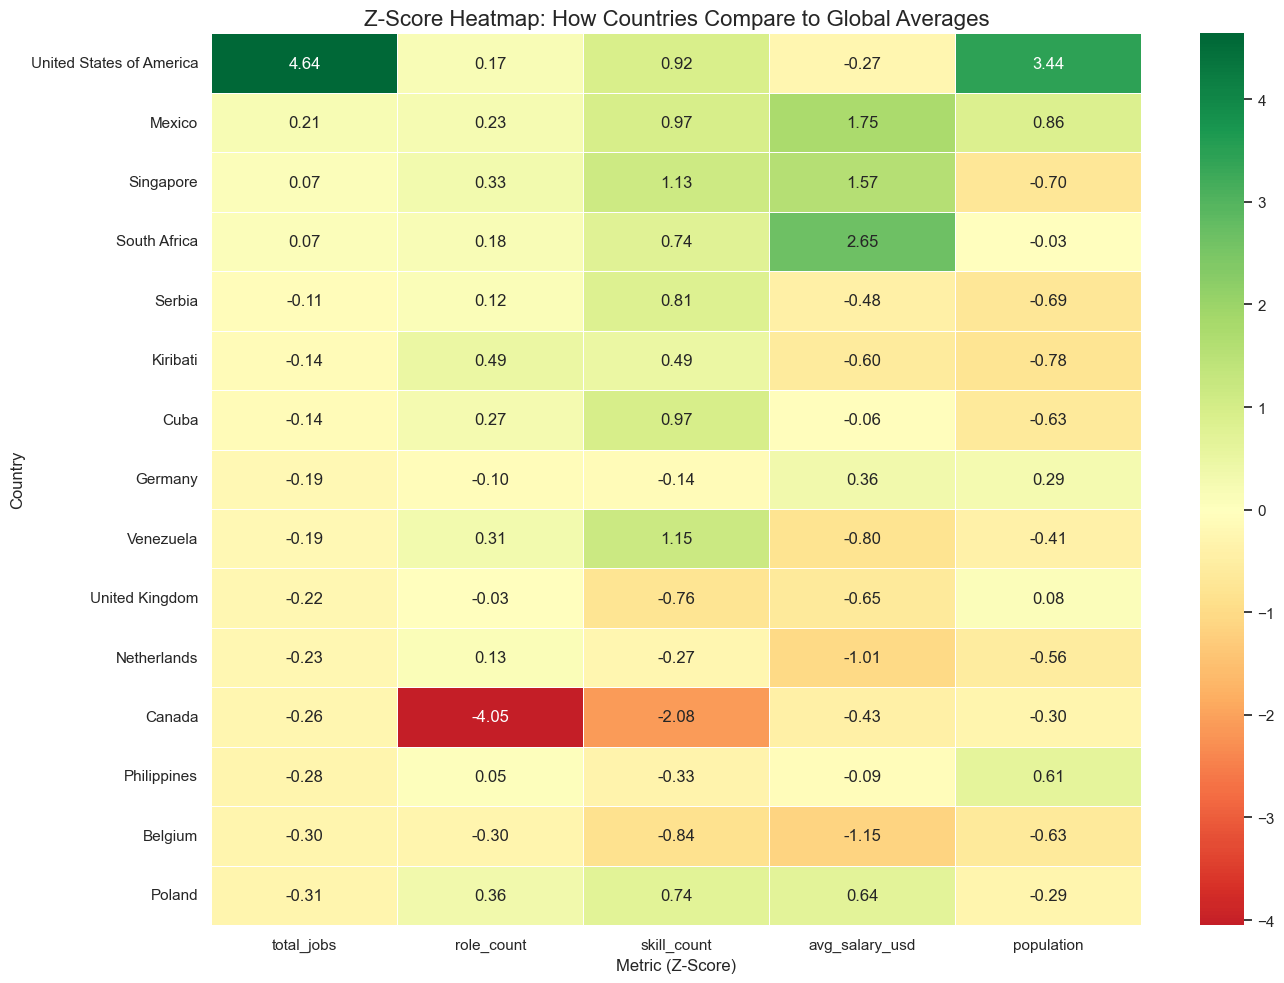

In [ ]:
# STEP 2.14: Z - SCORE ANALYSIS
from scipy.stats import zscore

# Select key metrics for Z-Score analysis
# Using the aggregated df_country_stats from Step 5
cols_to_zscore = ['total_jobs', 'role_count', 'skill_count', 'avg_salary_usd', 'population']

# Compute Z-scores (z = (x - mean) / std)
# We handle potential NaN or infinity results to keep the heatmap clean
df_zscore = df_country_stats[cols_to_zscore].apply(zscore)

# Handle countries with very few data points if needed
# (Optional: Filter out countries with total_jobs below a certain threshold for cleaner stats)
# df_zscore = df_zscore[df_country_stats['total_jobs'] > 5]

# Visualization
plt.figure(figsize=(14, 10))

# Sorting by total_jobs to see how the biggest markets compare across other metrics
# Using RdYlGn (Red-Yellow-Green) where Green = Above Average, Red = Below Average
sns.heatmap(df_zscore.sort_values('total_jobs', ascending=False).head(15),
            annot=True,
            cmap='RdYlGn',
            center=0,
            fmt=".2f",
            linewidths=0.5)

# Formatting
plt.title('Z-Score Heatmap: How Countries Compare to Global Averages', fontsize=16)
plt.ylabel('Country')
plt.xlabel('Metric (Z-Score)')
plt.tight_layout()
plt.show()

### STEP 3: EDA LEVEL 2
#### - Exploratory Data Analysis (EDA) 
#### - Level 2: Relationships & Aggregation

In [ ]:
# STEP 3.1: FEATURE SELECTION FOR COUNTRY-LEVEL CLUSTERING

# Chọn các biến đặc trưng (features) ở cấp độ COUNTRY và gom chúng thành một ma trận số để chuẩn bị cho clustering.
kdf = df_country_stats[['total_jobs','role_count','skill_count','avg_salary_usd','population']]
# Đơn vị phân tích: Country (mỗi dòng = 1 quốc gia)
# Lấy các chỉ số đại diện cho mỗi quốc gia:
    # total_jobs → quy mô thị trường
    # role_count → độ đa dạng vai trò
    # skill_count → độ phức tạp yêu cầu kỹ năng
    # avg_salary_usd → mức lương trung bình
    # population → bối cảnh nhân khẩu học

kdf.head()

,total_jobs,role_count,skill_count,avg_salary_usd,population
country,,,,,
Australia,61,0.737705,1.442623,135046.90,25364307.0
Austria,97,1.103093,2.618557,294320.00,8877067.0
Belgium,179,0.938547,2.670391,60000.00,11484055.0
Brazil,141,1.070922,4.177305,208000.00,211049527.0
Canada,317,0.397476,1.678233,121715.69,37589262.0


In [ ]:
# STEP 3.2: K-MEANS CLUSTERING

# Setup K-Means Clustering 
kmeans = KMeans(
    n_clusters=3,
    random_state=42
)

# Fit the model and predict clusters
kdf['cluster'] = kmeans.fit_predict(kdf)

kdf

,total_jobs,role_count,skill_count,avg_salary_usd,population,cluster
country,,,,,,
Australia,61,0.737705,1.442623,135046.900000,25364307.0,1
Austria,97,1.103093,2.618557,294320.000000,8877067.0,1
Belgium,179,0.938547,2.670391,60000.000000,11484055.0,1
Brazil,141,1.070922,4.177305,208000.000000,211049527.0,2
Canada,317,0.397476,1.678233,121715.690000,37589262.0,1
Cuba,768,1.019531,4.114583,152500.000000,11333483.0,1
Germany,612,0.967320,3.228758,188516.000000,83132799.0,0
Kiribati,771,1.051881,3.731518,107000.130300,312000.0,1
Mexico,2065,1.015012,4.111380,306862.400000,127575529.0,0


In [ ]:
# STEP 3.2: K-MEANS CLUSTERING

# Cluster profiling (mean feature summary per cluster)
cluster_means = (
    kdf
    .groupby('cluster')[[
        'total_jobs',
        'role_count',
        'skill_count',
        'avg_salary_usd',
        'population'
    ]]
    .mean()
    .reset_index()
)

cluster_means

,cluster,total_jobs,role_count,skill_count,avg_salary_usd,population
0,0,755.250000,1.017063,3.246180,181579.108056,1.157996e+08
1,1,481.470588,0.965998,3.270889,150886.513553,2.307244e+07
2,2,9351.500000,1.038640,4.126606,171527.011497,2.696445e+08


In [ ]:
# STEP 3.2: K-MEANS CLUSTERING

# Prepare data for visualization (format)
plot_df = cluster_means.melt(
    id_vars='cluster',
    value_vars=[
        'total_jobs',
        'role_count',
        'skill_count',
        'avg_salary_usd',
        'population'
    ],
    var_name='feature',
    value_name='mean_value'
)

plot_df

,cluster,feature,mean_value
0,0,total_jobs,7.552500e+02
1,1,total_jobs,4.814706e+02
2,2,total_jobs,9.351500e+03
3,0,role_count,1.017063e+00
4,1,role_count,9.659983e-01
5,2,role_count,1.038640e+00
6,0,skill_count,3.246180e+00
7,1,skill_count,3.270889e+00
8,2,skill_count,4.126606e+00
9,0,avg_salary_usd,1.815791e+05


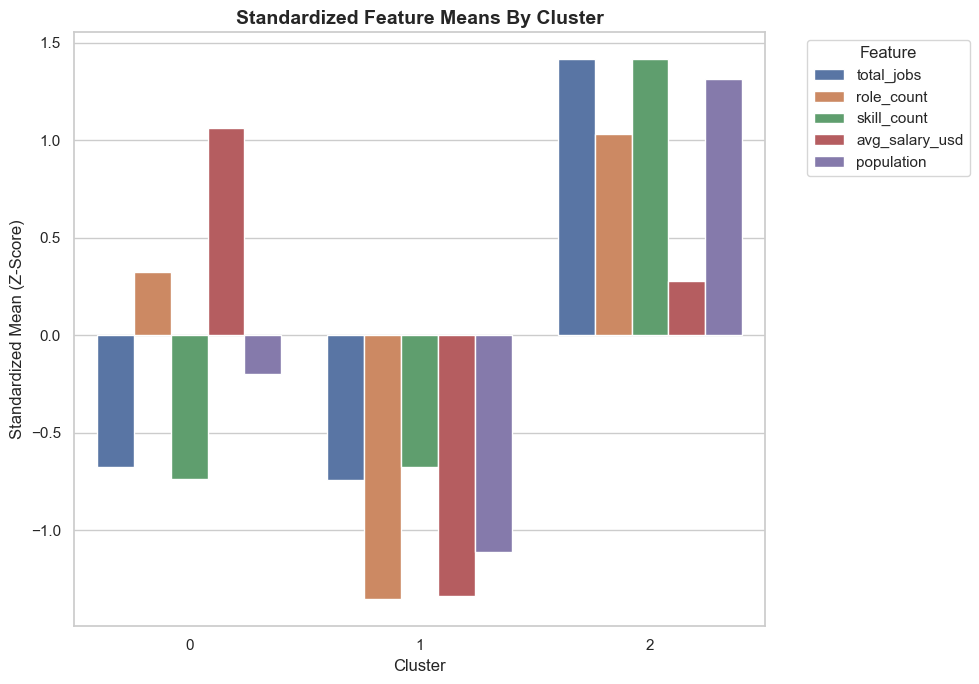

In [ ]:
# STEP 3.2: K-MEANS CLUSTERING
# Cluster Z-Score Profiling And Visualization

# Copy Data
df1 = kdf.copy()

# Select Features For Clustering
features = [
    'total_jobs',
    'role_count',
    'skill_count',
    'avg_salary_usd',
    'population'
]

# Compute Mean Per Cluster
cluster_means = (
    df1
    .groupby('cluster')[features]
    .mean()
    .reset_index()
)

# Reshape Cluster Means To Long Format
plot_df = cluster_means.melt(
    id_vars='cluster',
    value_vars=features,
    var_name='feature',
    value_name='mean_value'
)

# Standardize Feature Means Using Z-Score
plot_df['scaled_value'] = (
    plot_df
    .groupby('feature')['mean_value']
    .transform(
        lambda x: StandardScaler()
        .fit_transform(x.values.reshape(-1, 1))
        .flatten()
    )
)

# Visualize Standardized Feature Profiles By Cluster
plt.figure(figsize=(10, 7))

sns.barplot(
    data=plot_df,
    x='cluster',
    y='scaled_value',
    hue='feature',
    errorbar=None
)

plt.title(
    "Standardized Feature Means By Cluster",
    fontsize=14,
    fontweight='bold'
)
plt.xlabel("Cluster")
plt.ylabel("Standardized Mean (Z-Score)")
plt.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### STEP 4: PCA
#### - Principal Component Analysis (PCA) 
#### - K-Means Clustering

C:\Users\Zyro\AppData\Local\Temp\ipykernel_17080\100455573.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_country_stats = df.groupby('country').agg({


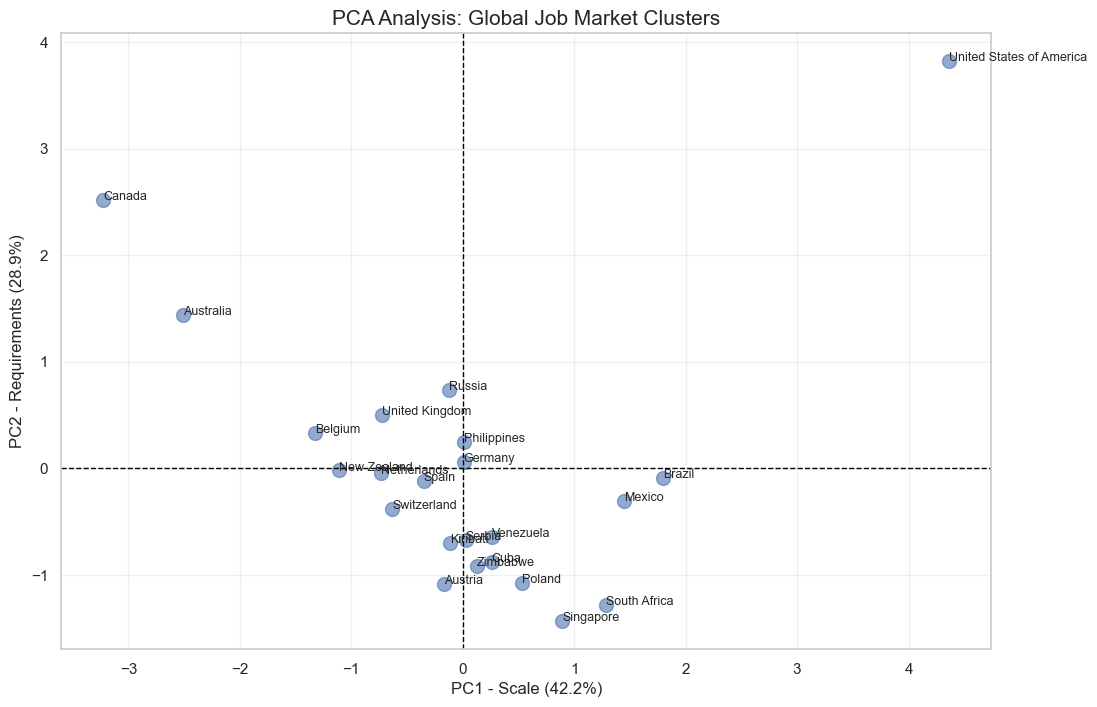

=== VARIABLE LOADINGS ===
                     PC1       PC2
total_jobs      0.474448  0.524432
role_count      0.423182 -0.464751
skill_count     0.538353 -0.375461
min_salary      0.278494 -0.332363
population_num  0.477946  0.507485


In [ ]:
# STEP 4.1: UNSUPERVISED MODELING – PCA

# Step 4.1.1: FEATURE ENGINEERING & CLEANING
def count_items(text):
    if pd.isna(text) or str(text).strip() == "" or str(text).lower() == 'nan':
        return 0
    return len([i.strip() for i in str(text).split(',') if i.strip() != ""])

# Create proxy for roles from industry and skills from job_description
df['role_count'] = df['roles'].astype(str).apply(count_items)
df['skill_count'] = df['skills'].astype(str).apply(count_items)

# Convert salary and population to numeric, handling missing values with the median
df['min_salary_usd'] = pd.to_numeric(df['min_salary'], errors='coerce')
df['population_num'] = pd.to_numeric(df['population'], errors='coerce')

# STEP 4.1.2: AGGREGATION BY COUNTRY
# We aggregate to find the "average" market profile for each country
df_country_stats = df.groupby('country').agg({
    'job_id': 'count',
    'role_count': 'mean',
    'skill_count': 'mean',
    'min_salary': 'median', # Using median due to high sparsity in salary data
    'population_num': 'first'
}).rename(columns={'job_id': 'total_jobs'}).dropna()

# STEP 4.1.3: PCA EXECUTION
features = ['total_jobs', 'role_count', 'skill_count', 'min_salary', 'population_num']
x = df_country_stats[features]

# Standardize the data (Mean=0, Variance=1)
scaler = StandardScaler()
x_std = scaler.fit_transform(x)

# Apply PCA
pca = PCA(n_components=2)
pc_scores = pca.fit_transform(x_std)

# Create a DataFrame for the results
pca_df = pd.DataFrame(data=pc_scores,
                      columns=['PC1 (Market Scale)', 'PC2 (Job Requirements)'],
                      index=x.index)

# STEP 4.1.4: VISUALIZATION
plt.figure(figsize=(12, 8))
plt.scatter(pca_df['PC1 (Market Scale)'], pca_df['PC2 (Job Requirements)'], alpha=0.6, s=100)

for i, txt in enumerate(pca_df.index):
    plt.annotate(txt, (pca_df.iloc[i, 0], pca_df.iloc[i, 1]), fontsize=9)

plt.axhline(0, color='black', lw=1, ls='--')
plt.axvline(0, color='black', lw=1, ls='--')
plt.title('PCA Analysis: Global Job Market Clusters', fontsize=15)
plt.xlabel(f'PC1 - Scale ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 - Requirements ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.grid(True, alpha=0.3)
plt.show()

# Show variable influence
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features)
print("=== VARIABLE LOADINGS ===")
print(loadings)

Clustering based on: ['PC1 (Market Scale)', 'PC2 (Job Requirements)']


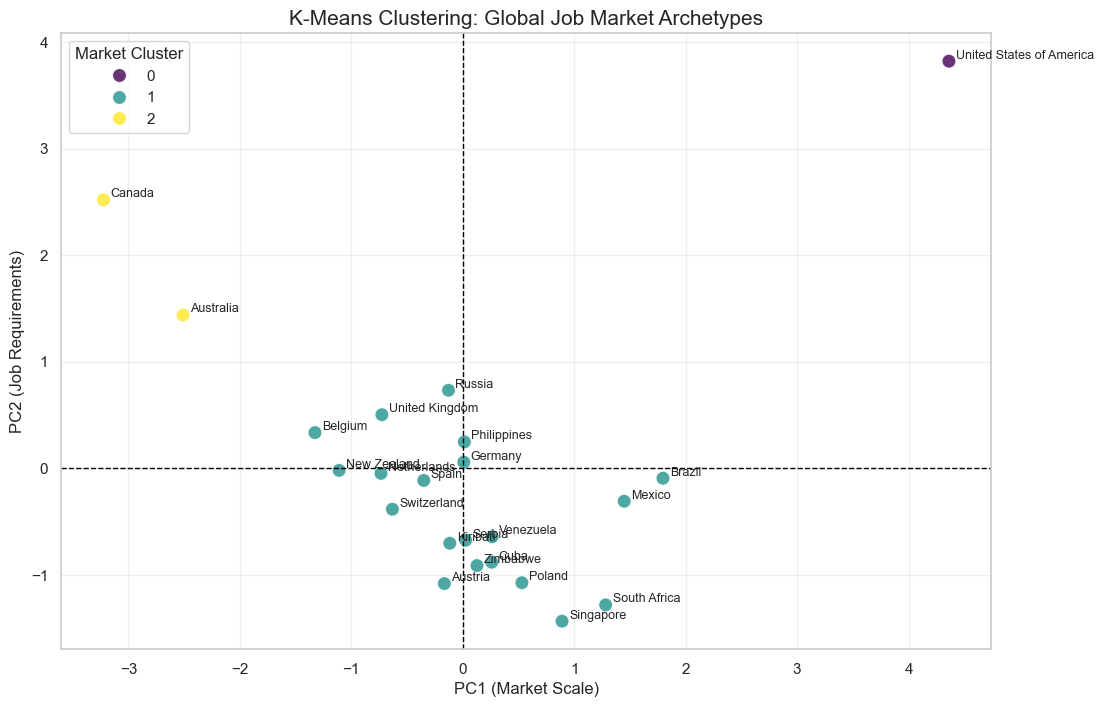

Cluster 0: United States of America
Cluster 1: Austria, Belgium, Brazil, Cuba, Germany, Kiribati, Mexico, Netherlands, New Zealand, Philippines, Poland, Russia, Serbia, Singapore, South Africa, Spain, Switzerland, United Kingdom, Venezuela, Zimbabwe
Cluster 2: Australia, Canada


In [ ]:
# STEP 4.2: K-MEANS CLUSTERING ON PCA SPACE
# Prepare PCA DataFrame for Clustering (chuẩn bị chạy KMeans trên không gian PCA)

# STEP 4.2.1: Automatically detect the PCA column names to avoid KeyErrors
pca_cols = pca_df.columns[:2].tolist()
print(f"Clustering based on: {pca_cols}")

# STEP 4.2.2: Run K-Means
# We use .fit_predict() which is cleaner for assigning cluster labels
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
pca_df['Cluster'] = kmeans.fit_predict(pca_df[pca_cols])

# STEP 4.2.3: Visualize the Clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x=pca_cols[0], y=pca_cols[1],
                hue='Cluster', palette='viridis', s=100, alpha=0.8, edgecolor='w')

# Annotate country names for clarity
for i, txt in enumerate(pca_df.index):
    plt.annotate(txt, (pca_df.iloc[i, 0], pca_df.iloc[i, 1]),
                 fontsize=9, xytext=(5,2), textcoords='offset points')

plt.title('K-Means Clustering: Global Job Market Archetypes', fontsize=15)
plt.axhline(0, color='black', lw=1, ls='--')
plt.axvline(0, color='black', lw=1, ls='--')
plt.grid(True, alpha=0.3)
plt.legend(title='Market Cluster')
plt.show()

# STEP 4.2.4: View which countries fell into which cluster
for cluster_id in range(3):
    countries = pca_df[pca_df['Cluster'] == cluster_id].index.tolist()
    print(f"Cluster {cluster_id}: {', '.join(countries)}")

In [ ]:
# STEP 4.2: K-MEANS CLUSTERING ON PCA SPACE

# STEP 4.2.5: Check df
df.head()

,job_id,company_id,location_id,posted_date,min_salary,max_salary,currency,required_exp_years,education_level,employment_type,job_description,remote_option,company_name,size,industry,city,country,country_iso,latitude,longitude,population,roles,job_level,skill_names,skill_ids,skill_categories,ex_rate,min_salary_usd,max_salary_usd,avg_salary_usd,skills,role_count,skill_count,population_num
0,119761,17828,4493,2025-05-31,120000.0,140000.0,USD,NaN,Master,Full-time,Enterprise Account Executi...,Remote,Maslow,Enterprise,Technology,Auckland,New Zealand,NZ,-41.662579,172.701926,4917000.0,,Lead,nan,nan,nan,1.0,120000.0,140000.0,130000.0,,0,0,4917000.0
1,1088383,153166,4700,2025-01-11,NaN,NaN,NaN,NaN,NaN,Full-time,__NA__,Onsite,MASTER PLUS HUMAN RESOURCE...,NaN,NaN,Oshkosh,United States of America,US,45.705628,-112.599436,328239523.0,Data Engineer,NaN,"Azure, AWS, Kafka, Terrafo...","1, 10, 11, 17, 18, 20, 23,...","Cloud,Data Engineering,Dev...",1.0,NaN,NaN,NaN,"Azure, AWS, Kafka, Terrafo...",1,9,328239523.0
2,853689,32657,1406,2024-06-08,NaN,NaN,NaN,NaN,NaN,Full-time,__NA__,Onsite,RemoteWorker UK,NaN,NaN,London Village,Kiribati,KI,1.873200,-157.429600,312000.0,Data Scientist,NaN,"Azure, Python, AWS, GCP, G...","1, 9, 10, 15, 37, 57, 134,...","Cloud,Programming,DevOps,V...",1.0,NaN,NaN,NaN,"Azure, Python, AWS, GCP, G...",1,8,312000.0
3,850850,95060,5439,2024-06-03,NaN,NaN,NaN,NaN,NaN,Full-time,__NA__,Onsite,25-я городская детская пол...,NaN,NaN,Minsk Mazowiecki,Poland,PL,52.148260,19.311014,37970874.0,Data Analyst,NaN,nan,nan,nan,1.0,NaN,NaN,NaN,,1,0,37970874.0
4,920654,66126,5394,2024-09-12,NaN,NaN,NaN,NaN,NaN,Full-time,__NA__,Onsite,Bbva Renting,NaN,NaN,Bogota,United States of America,US,45.705628,-112.599436,328239523.0,Data Analyst,NaN,"SQL, Python, Spark, PowerP...","8, 9, 18, 41","Database,Programming,Data ...",1.0,NaN,NaN,NaN,"SQL, Python, Spark, PowerP...",1,4,328239523.0


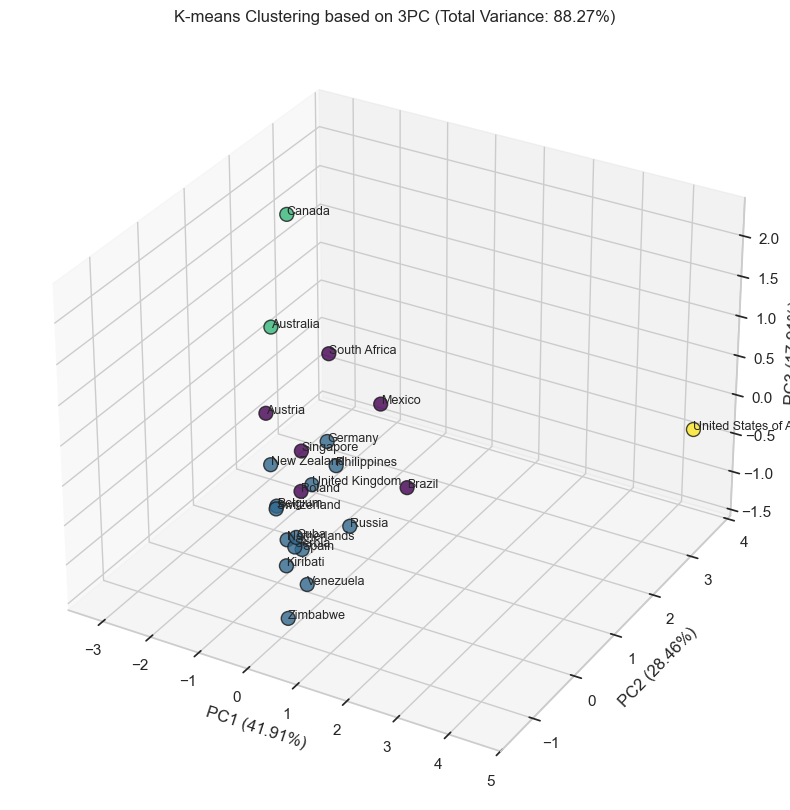

PCA 3D Loadings:
                     PC1       PC2       PC3
total_jobs      0.486265  0.516004 -0.014903
role_count      0.418170 -0.498914 -0.406074
skill_count     0.529094 -0.395052 -0.136208
avg_salary_usd  0.254798 -0.296580  0.902679
population      0.493780  0.490712  0.038723


In [ ]:
# STEP 4.3: PCA-BASED 3D K-MEANS CLUSTERING
# Dùng để vẽ đồ thị 3D

# STEP 4.3.1: PCA VỚI 3 THÀNH PHẦN CHÍNH ---
# Sử dụng df_zscore từ bước trước của bạn
data_pca_3d = df_zscore.dropna()
pca_3 = PCA(n_components=3)
pca_results_3d = pca_3.fit_transform(data_pca_3d)

# Tạo DataFrame chứa kết quả 3PC
df_3pc = pd.DataFrame(
    data = pca_results_3d,
    columns = ['PC1', 'PC2', 'PC3'],
    index = data_pca_3d.index
).reset_index()

# STEP 4.3.2: K-MEANS CLUSTERING DỰA TRÊN 3PC
# Giả sử chúng ta chọn K=4 cụm để phân hóa rõ hơn các nhóm nước
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_3pc['cluster'] = kmeans.fit_predict(pca_results_3d) # Chạy trên cả 3 cột PC

# STEP 4.3.3: TRỰC QUAN HÓA 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Vẽ các điểm dữ liệu theo 3 trục PC, màu sắc theo Cluster
scatter = ax.scatter(df_3pc['PC1'], df_3pc['PC2'], df_3pc['PC3'],
                     c=df_3pc['cluster'], cmap='viridis', s=100, edgecolors='k', alpha=0.8)

# Thêm nhãn tên quốc gia (để tránh rối, chỉ hiện nhãn cho một số nước tiêu biểu)
for i in range(df_3pc.shape[0]):
    ax.text(df_3pc.PC1[i], df_3pc.PC2[i], df_3pc.PC3[i], df_3pc['country'][i], size=9)

# Giải thích các trục
pc_vars = pca_3.explained_variance_ratio_ * 100
ax.set_xlabel(f'PC1 ({pc_vars[0]:.2f}%)')
ax.set_ylabel(f'PC2 ({pc_vars[1]:.2f}%)')
ax.set_zlabel(f'PC3 ({pc_vars[2]:.2f}%)')

plt.title(f'K-means Clustering based on 3PC (Total Variance: {pc_vars.sum():.2f}%)')
plt.show()

# In Loadings để giải thích PC3 là gì
loadings_3d = pd.DataFrame(pca_3.components_.T, columns=['PC1', 'PC2', 'PC3'], index=cols_to_zscore)
print("PCA 3D Loadings:")
print(loadings_3d)

C:\Users\Zyro\AppData\Local\Temp\ipykernel_17080\3127844482.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  country_data = df.groupby('country').agg({


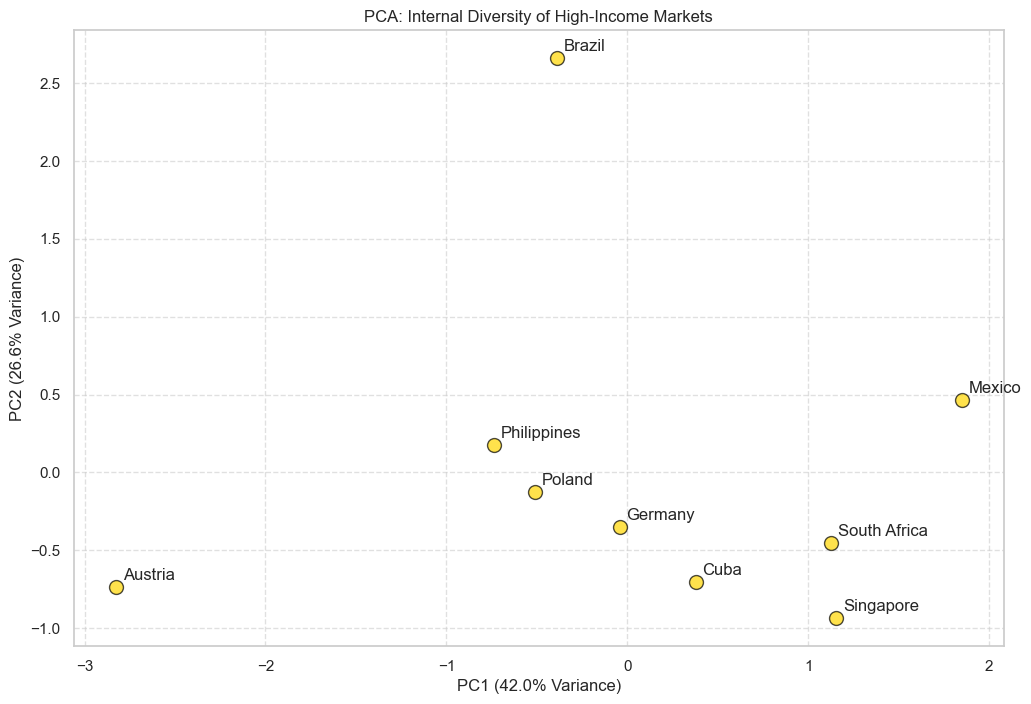

Loadings Analysis:
                  PC1       PC2
total_jobs   0.664399 -0.240478
role_count  -0.427341  0.219730
skill_count  0.603928  0.260601
population   0.105947  0.908832


In [ ]:
# STEP 4.4: FOCUSED PCA ANALYSIS OF HIGH-INCOME MARKETS

# STEP 4.4.1: Tổng hợp dữ liệu theo quốc gia (vì PCA cần so sánh giữa các quốc gia)
country_data = df.groupby('country').agg({
    'avg_salary_usd': 'mean',
    'job_id': 'count',          # Đây chính là total_jobs
    'role_count': 'mean',
    'skill_count': 'mean',
    'population': 'first'       # Lấy giá trị dân số đầu tiên của quốc gia đó
}).rename(columns={'job_id': 'total_jobs'}).dropna()

# STEP 4.4.2: Bây giờ mới lọc nhóm "thu nhập cao" từ bảng đã tổng hợp
high_income_countries = country_data[country_data['avg_salary_usd'] > 140000].copy()

# STEP 4.4.3: Chọn các biến làm PCA
features = ['total_jobs', 'role_count', 'skill_count', 'population']
x = high_income_countries[features]

# STEP 4.4.4: Chuẩn hóa và chạy PCA
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

pca_high = PCA(n_components=2)
pc_results = pca_high.fit_transform(x_scaled)

# STEP 4.4.5: Tạo DataFrame kết quả để vẽ biểu đồ có tên quốc gia
pca_df = pd.DataFrame(data=pc_results, columns=['PC1', 'PC2'], index=high_income_countries.index)

# STEP 4.4.6: Vẽ biểu đồ PCA có tên quốc gia (Annotate)
plt.figure(figsize=(12, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'], s=100, alpha=0.7, c='gold', edgecolors='black')

for i, txt in enumerate(pca_df.index):
    plt.annotate(txt, (pca_df['PC1'].iloc[i], pca_df['PC2'].iloc[i]), xytext=(5,5), textcoords='offset points')

plt.title('PCA: Internal Diversity of High-Income Markets')
plt.xlabel(f'PC1 ({pca_high.explained_variance_ratio_[0]:.1%} Variance)')
plt.ylabel(f'PC2 ({pca_high.explained_variance_ratio_[1]:.1%} Variance)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Xuất Loadings để phân tích
loadings = pd.DataFrame(pca_high.components_.T, columns=['PC1', 'PC2'], index=features)
print("Loadings Analysis:")
print(loadings)

C:\Users\Zyro\AppData\Local\Temp\ipykernel_17080\1100978959.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=skills_df, x='Count', y='Skill', palette='magma')


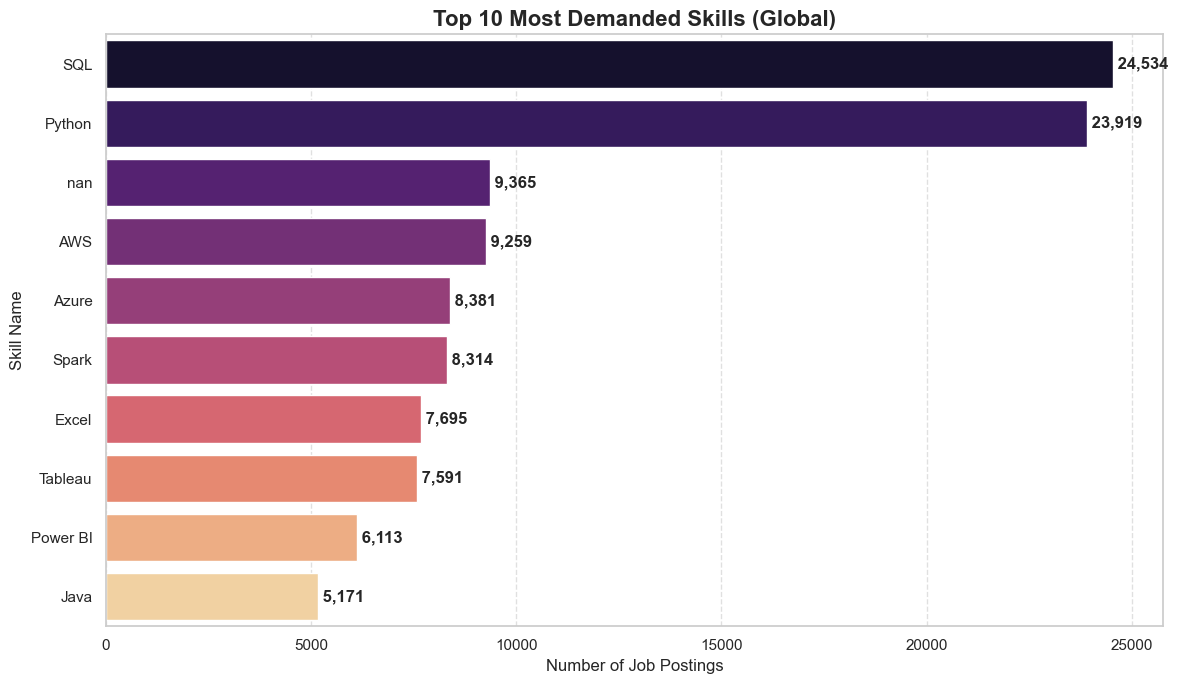

In [ ]:
# STEP 4.5 GLOBAL SKILL DEMAND ANALYSIS

# STEP 4.5.1: Identify the correct column (using 'skill_names' from your dataset)
source_col = 'skill_names'

# STEP 4.5.2: Extract and flatten the skills list
# We split by comma, drop nulls, and flatten the list of lists into one long list
all_skills_list = []
df[source_col].dropna().apply(lambda x: all_skills_list.extend([s.strip() for s in str(x).split(',') if s.strip()]))

# STEP 4.5.3. Count frequencies and create a DataFrame
skill_counts = Counter(all_skills_list).most_common(10)
skills_df = pd.DataFrame(skill_counts, columns=['Skill', 'Count'])

# STEP 4.5.4. Plotting
plt.figure(figsize=(12, 7))
sns.barplot(data=skills_df, x='Count', y='Skill', palette='magma')

# Add data labels for clarity
for index, value in enumerate(skills_df['Count']):
    plt.text(value, index, f' {value:,.0f}', va='center', fontweight='bold')

plt.title('Top 10 Most Demanded Skills (Global)', fontsize=16, fontweight='bold')
plt.xlabel('Number of Job Postings')
plt.ylabel('Skill Name')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
# STEP 4.5 GLOBAL SKILL DEMAND ANALYSIS

# Step 4.5.5: Check df
df.head()

,job_id,company_id,location_id,posted_date,min_salary,max_salary,currency,required_exp_years,education_level,employment_type,job_description,remote_option,company_name,size,industry,city,country,country_iso,latitude,longitude,population,roles,job_level,skill_names,skill_ids,skill_categories,ex_rate,min_salary_usd,max_salary_usd,avg_salary_usd,skills,role_count,skill_count,population_num
0,119761,17828,4493,2025-05-31,120000.0,140000.0,USD,NaN,Master,Full-time,Enterprise Account Executi...,Remote,Maslow,Enterprise,Technology,Auckland,New Zealand,NZ,-41.662579,172.701926,4917000.0,,Lead,nan,nan,nan,1.0,120000.0,140000.0,130000.0,,0,0,4917000.0
1,1088383,153166,4700,2025-01-11,NaN,NaN,NaN,NaN,NaN,Full-time,__NA__,Onsite,MASTER PLUS HUMAN RESOURCE...,NaN,NaN,Oshkosh,United States of America,US,45.705628,-112.599436,328239523.0,Data Engineer,NaN,"Azure, AWS, Kafka, Terrafo...","1, 10, 11, 17, 18, 20, 23,...","Cloud,Data Engineering,Dev...",1.0,NaN,NaN,NaN,"Azure, AWS, Kafka, Terrafo...",1,9,328239523.0
2,853689,32657,1406,2024-06-08,NaN,NaN,NaN,NaN,NaN,Full-time,__NA__,Onsite,RemoteWorker UK,NaN,NaN,London Village,Kiribati,KI,1.873200,-157.429600,312000.0,Data Scientist,NaN,"Azure, Python, AWS, GCP, G...","1, 9, 10, 15, 37, 57, 134,...","Cloud,Programming,DevOps,V...",1.0,NaN,NaN,NaN,"Azure, Python, AWS, GCP, G...",1,8,312000.0
3,850850,95060,5439,2024-06-03,NaN,NaN,NaN,NaN,NaN,Full-time,__NA__,Onsite,25-я городская детская пол...,NaN,NaN,Minsk Mazowiecki,Poland,PL,52.148260,19.311014,37970874.0,Data Analyst,NaN,nan,nan,nan,1.0,NaN,NaN,NaN,,1,0,37970874.0
4,920654,66126,5394,2024-09-12,NaN,NaN,NaN,NaN,NaN,Full-time,__NA__,Onsite,Bbva Renting,NaN,NaN,Bogota,United States of America,US,45.705628,-112.599436,328239523.0,Data Analyst,NaN,"SQL, Python, Spark, PowerP...","8, 9, 18, 41","Database,Programming,Data ...",1.0,NaN,NaN,NaN,"SQL, Python, Spark, PowerP...",1,4,328239523.0


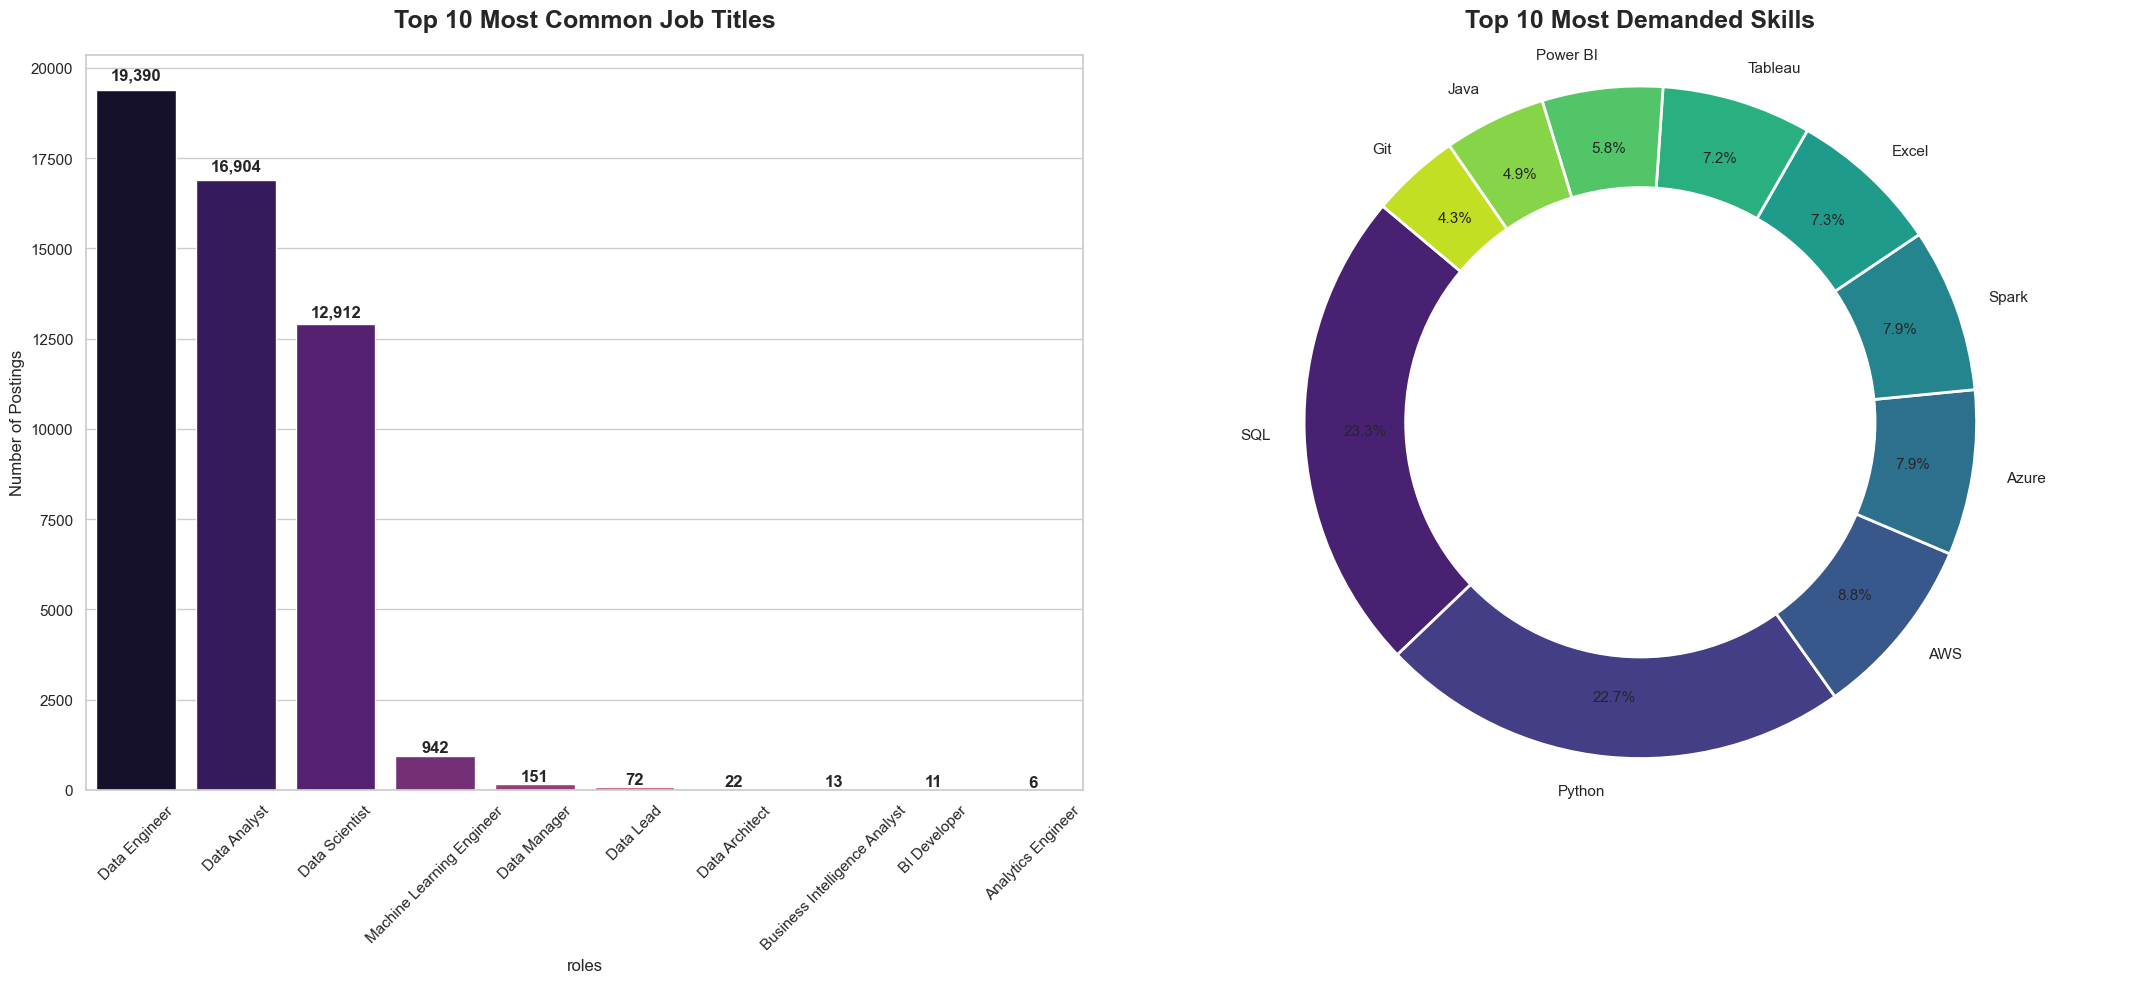

In [ ]:
# STEP 4.6: GLOBAL JOB TITLE AND SKILL DEMAND ANALYSIS

# STEP 4.6.1: Data Processing

# Process Skills
all_skills_list = []
df['skill_names'].dropna().apply(
    lambda x: all_skills_list.extend(
        [s.strip() for s in str(x).split(',') if s.strip().lower() != 'nan']
    )
)
skills_df = pd.DataFrame(
    Counter(all_skills_list).most_common(10),
    columns=['Skill', 'Count']
)

# Process Job Titles
all_titles_list = []
df['roles'].dropna().apply(
    lambda x: all_titles_list.extend(
        [t.strip() for t in str(x).split(',') if t.strip()]
    )
)
jobs_df = pd.DataFrame(
    Counter(all_titles_list).most_common(10),
    columns=['roles', 'Count']
)

# STEP 4.6.2: Plotting

fig, axes = plt.subplots(1, 2, figsize=(22, 10))

# ===== LEFT: Job Titles (Bar Chart) =====
sns.barplot(
    data=jobs_df,
    x='roles',
    y='Count',
    ax=axes[0],
    palette='magma',
    hue='roles'
)
if axes[0].get_legend():
    axes[0].get_legend().remove()

axes[0].set_title(
    'Top 10 Most Common Job Titles',
    fontsize=18,
    fontweight='bold',
    pad=20
)
axes[0].tick_params(axis='x', rotation=45, labelsize=11)
axes[0].set_ylabel('Number of Postings', fontsize=12)

# Add data labels
for index, value in enumerate(jobs_df['Count']):
    axes[0].text(
        index,
        value + value * 0.01,
        f'{value:,.0f}',
        ha='center',
        va='bottom',
        fontweight='bold'
    )

# ===== RIGHT: Skills (Donut Chart) =====
colors = sns.color_palette('viridis', n_colors=len(skills_df))
wedges, texts, autotexts = axes[1].pie(
    skills_df['Count'],
    labels=skills_df['Skill'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    pctdistance=0.82,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2},
    textprops={'fontsize': 11}
)

# Donut hole
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
axes[1].add_artist(centre_circle)

axes[1].set_title(
    'Top 10 Most Demanded Skills',
    fontsize=18,
    fontweight='bold',
    pad=20
)
axes[1].axis('equal')

plt.tight_layout()
plt.show()


In [ ]:
df.head()